# Text-mining-applied-project
### Busqueda y Recuperacion de Informacion 
Se busca construir un sistema de busqueda y recuperacion de informacion que sea capáz de identificar informacion relavante para el usuario en grandes volumnes de información (Documentos Cientificos). Este proceso se lleva a cabo mediante la construcción de un Bag of Words, metodo utilizado para representar la información de los documentos en palabras.

In [4]:
import glob # libreria para extraer la ruta de los archivos
import re # libreria para manejos de expresiones regulares
import collections #### para poder contar los hash
import pandas as pd # libreria para manejo de bases datos
import numpy as np # libreria para manejo de vectores y arreglos
import json #libreria para leer los metadatos guardados como un json
import operator #Libreria para organizar de mayor a menor
import matplotlib.pyplot as plt #libreria para graficas
from nltk.corpus import stopwords, wordnet # importa las stop words y las palabras del ingles
from nltk.stem.porter import PorterStemmer # metodo para stemming
from nltk.stem.lancaster import LancasterStemmer # metodo para stemming
from nltk.stem import WordNetLemmatizer # metodo para lematizar

### Creación del Bag of Words
Para la creacion del Bag of Words se construye una lista de todos los documentos cientificos almacenados en formato txt, luego se extrae el texto de cada uno de los documentos y se realiza una limpieza para cada una de las palabras en los diferentes documentos. Entre los procesos de limpieza estan:
* Tokenización: Es el proceso de separa un texto en cadenas separadas por espacios o signos de puntuacion.
* Eliminar Stopwords: Eliminar palabras como artículos, conjunciones y preposiciones.
* Stemming: Eliminar los sufijos de la palabra usando PorterStemmer dela libreria NLTK.
* Lemmatization: Proceso de convertir la palabra en la raiz
* Otros: Limpieza de palabras de 1 caracter y palabras pertenecientes al ingles

La estructura de datos que almancena el Bag of Words es ```[:documento][:palabra][:propiedades] ```

In [ ]:
#Read Files
files_txt = glob.glob("/opt/datasets/mcda-pi1-20191/papers-txt/*.txt")

# instanciar la clase para lematizar
wordnet_lemmatizer = WordNetLemmatizer()
# llamamos al diccionario de stop words en ingles
sw = stopwords.words("english")

#leer Meta Datos
meta_data = open("xml_parser/metadata_dict.txt","r",encoding='utf-8').read()
meta_data = json.loads(meta_data)

# Recorre los archivos para generar el bag of words
bag_of_words = {} # creacion de la estructura de datos (diccionario) para almacenar el bag of words
for file in files_txt:
    #Leer Informacion
    input_file = open(file,"r",encoding='utf-8')
    texto = input_file.read()
    meta_data_info = meta_data[file.split("/")[5].replace(".txt","")]
    
    #limpieza de palabras
    texto = re.sub('[^A-Za-z0-9]+',' ',texto) # solo permanecen los elementos alfanumericos
    tokens = texto.split() # Realiza la tokenizacion
    
    meta_data_info = re.sub('[^A-Za-z0-9]+',' ',meta_data_info) # solo permanecen los elementos alfanumericos
    tokens_metada = meta_data_info.split() # Realiza la tokenización
    
    stemmer = PorterStemmer() # instancia una forma de stemming
    # aplica lematizacion, stemming, elimina de stop words y aplica reglas lógicas para reducir la cantidad de tokens
    tokens = [wordnet_lemmatizer.lemmatize(stemmer.stem(w.lower()), pos="v") for w in tokens if (len(w)>1) and (w not in sw) and wordnet.synsets(w) and w.isalpha() ] # Longitud mayor a 1
    tokens_metada = [wordnet_lemmatizer.lemmatize(stemmer.stem(w.lower()), pos="v") for w in tokens if (len(w)>1) and (w not in sw)  ]
    
    # realiza el conteo de la frecuencia de cada palabra para cada documento
    counter = collections.Counter(tokens + tokens_metada)
    # para un diccionario almacenamos el key que es el nombre del documento y el value que es un diccionario con las key como palabras y los value como la frecuencia de la palabra
    bag_of_words[file] = dict(counter)


### Modelos
Dentro de los métodos para recuperar información de los textos, existen varios tipos de modelos. Por el momento, los modelos que están implementados para la recuperación de información son:
1.	Term Frequency (TF): Es la técnica más simple para reconocer la relevancia de un término dentro de un texto. Básicamente realiza el conteo de la palabra en el texto y mientras más grande sea este número más relevante es
2.	Relative Term Frequency (RTF): Está técnica vuelve relativo al número de palabras total el conteo anterior, representando entonces cuánto porcentaje del texto está explicado por esa palabra
3.	T-Term Frequency (T-TF): Para eliminar riesgos de modelo cuando se realiza el conteo lineal de la frecuencia de los términos, se propone trabajar con una transformación del conteo: T-TF = 1 + log(x) de esta manera no se benefician aquellas palabras que aparecen muchas veces en un documento, pues no necesariamente son más relevantes que las demás
4.	Inverse Document Frequency (IDF): Este modelo está basado en el principio de que mientras menor sea la frecuencia de la palabra en el documento, más relevante y más información puede tener IDF = log(# total de documentos/# de documentos donde está la palabra)
5.	TF-IDF: Al tener los modelos ya cuantificados, tanto el TF (recomendable trabajar con la transformación) y el IDF, la multiplicación de ambos entrega información valiosa de cara a la similaridad de la búsqueda o Query con el documento.


In [ ]:
#Contar numero de documentos donde se encuentra la palabra
helper = {}
for doc, words in bag_of_words.items():
    for word in words.keys():
        if word in helper:
            helper[word] += 1
        else:
            helper[word] = 1

#Para las palabras de cada documento asignar medidas
for documento, words in bag_of_words.items():
    num_words = sum(bag_of_words[documento].values())
    for key, value in words.items():
        dic = {}
        # Asignar medidas
        dic['freq'] = value # TF
        dic['freqR'] = value / num_words # RTF
        dic['tf'] = 1 + np.log(value) # T-TF
        dic['idf'] = np.log(len(bag_of_words) / helper[key]) # IDF
        dic['tf-idf'] = dic['tf'] * dic['idf'] # TF-IDF
        bag_of_words[documento][key] = dic


In [ ]:
bag_of_words['/opt/datasets/mcda-pi1-20191/papers-txt/1508.04417.txt']['user']

## Primer acercamiento a Busquedas 
Se debe realizar el mismo proceso de limpieza al query ya que con este se van a buscar las palabras en el Bag of Words para buscar y identificar los textos mas relevantes 

In [ ]:
#query
def transformar_informacion (texto):
    texto = re.sub('[^A-Za-z0-9]+',' ',texto) # Caracteres especiales
    texto = texto.replace('í','i')
    tokens = texto.split()
    stemmer = PorterStemmer()
    stemmer2 = LancasterStemmer()
    tokens = [wordnet_lemmatizer.lemmatize(stemmer.stem(w.lower()), pos="v") for w in tokens if (len(w)>1) and w.isalpha() and w not in sw and wordnet.synsets(w)] # Longitud mayor a 1
    counter=collections.Counter(tokens)
    return dict(counter)

texto = "Moving average are not good for trading"
query = transformar_informacion(texto)
query

### Realizar Busequeda
Despues de realizar la transformación del query utilizando los mismos proceso de limpieza que el Bag of Words, se busca cada palabra en el query para cada documento y se calcula ```[:palabra_query][:freq] * [:documento][:palabra][:tf]```

In [ ]:
result_query = {}
for documento, words in bag_of_words.items():
    for key, value in words.items():
        if key in query:
            if documento in result_query:
                result_query[documento] += query[key] * value['tf-idf']
            else:
                result_query[documento] = query[key] * value['tf-idf']

                
resultado = sorted(result_query.items(), key=operator.itemgetter(1), reverse=True)
print("Son {} resultados.... {}".format(len(resultado), resultado[:5]))

## Explorando Bag of Words

In [ ]:
#Contar documentos
len(bag_of_words)

In [ ]:
#Contar numero de palabras por documento despues de limpieza
x_doc = [] # documentos
y_doc = [] # num palabras unicas por doc
total_palabras_doc = [] # total palabras
for documento, words in bag_of_words.items():
    x_doc.append(documento)
    y_doc.append(len(words))
    numero_palabras = 0
    for word, values in words.items():
        numero_palabras += values['freq']
    total_palabras_doc.append(numero_palabras)

#Imprimir Solo un documento
print("El documento '{}' tiene {} palabras unicas despues del proceso de limpieza".format(x_doc[0][-15:], y_doc[0]))
print("El total de palabras contenido en el texto es de {}".format(total_palabras_doc[0]))

In [ ]:
palabras_raras = collections.OrderedDict()
palabras_tres_caracteres = collections.OrderedDict()
i = 0
for documento, words in bag_of_words.items():
    for word, values in words.items():
        if len(word) > 10 and values['freq'] < 2:
            palabras_raras[i] = word
            i+=1
        if bool(re.search(r'((\w)\2{2,})', word)):
            palabras_tres_caracteres[word] = values['idf']
palabras_raras

In [ ]:
palabras_tres_caracteres

#### Explorando Bag of Words

In [ ]:
#Buscar documentos con X palabra
#palabras
documentos_raros = []
for documento, words in bag_of_words.items():
    if 'bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb' in words:
        documentos_raros.append(documento)
documentos_raros

In [ ]:
#/opt/datasets/mcda-pi1-20191/papers-txt/1501.02741.txt
bag_of_words['/opt/datasets/mcda-pi1-20191/papers-txt/1501.02741.txt']['user']

input_file = open('/opt/datasets/mcda-pi1-20191/papers-txt/1501.02741.txt',"r",encoding='utf-8')
texto = input_file.read()
#texto = re.sub('[^A-Za-z0-9]+',' ',texto) # Caracteres especiales
tokens = texto.split()
stemmer = PorterStemmer()
stemmer2 = LancasterStemmer()
tokens = [wordnet_lemmatizer.lemmatize(stemmer.stem(w.lower()), pos="v") for w in tokens if (len(w)>1) and w.isalpha() and w not in sw] # Longitud mayor a 1
counter=collections.Counter(tokens)
dict(counter)['user']

In [ ]:
#Traductor
def detect_language(text):

    languages_ratios = {}
    tokens = tokens = texto.split()
    tokens = [w.lower() for w in tokens]
    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(tokens)
        common_elements = words_set.intersection(stopwords_set)
        languages_ratios[language] = len(common_elements) # language "score"
    return max(languages_ratios, key=languages_ratios.get)


#----------------------------------------------------------------------
input_file = open(files_txt[0],"r",encoding='utf-8')
texto = input_file.read()
language = detect_language(texto)
language

In [ ]:
bag_of_words['/opt/datasets/mcda-pi1-20191/papers-txt/1508.04417.txt']

In [ ]:
palabras_unicas = {}
for documento, words in bag_of_words.items():
    for word, values in words.items():
        if word not in palabras_unicas:
            palabras_unicas[word] = 1
len(palabras_unicas)

print (palabras_unicas)

# Analisis paso a paso

In [5]:
def mostrar_info(estadisticas_tamano,mensaje="estadisticas"):
    lista_estadisticas = list(estadisticas_tamano.values())
    print("""Info {}:
    - minimo:   {}
    - maximo:   {}
    - promedio: {}
    - mediana:  {}
    - total:    {}
    """.format(mensaje,
               np.min(lista_estadisticas), 
               np.max(lista_estadisticas),
               np.mean(lista_estadisticas),
               np.median(lista_estadisticas),
               np.sum(lista_estadisticas)))
    plt.bar(*zip(*sorted(estadisticas_tamano.items(), key=operator.itemgetter(1), reverse=True)[:5]), align='center', alpha=0.5)
    plt.title('Doc Mayor numero de palabras')
    plt.show()
    plt.bar(*zip(*sorted(estadisticas_tamano.items(), key=operator.itemgetter(1), reverse=True)[-5:]), align='center', alpha=0.5)
    plt.title('Doc Menor numero de palabras')
    plt.show()
    plt.hist(lista_estadisticas)
    plt.title('Histograma')
    plt.show()
    plt.boxplot(lista_estadisticas)
    plt.title('Boxplot')
    plt.show()

El tamaño total de documentos es de 980
Info sin ningun proceso de limpieza:
    - minimo:   685
    - maximo:   311961
    - promedio: 12900.557142857142
    - mediana:  10285.5
    - total:    12642546
    


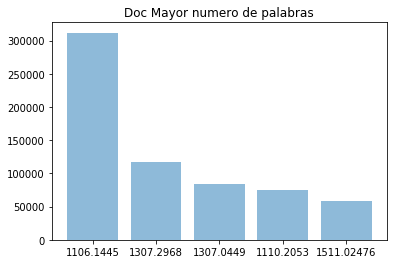

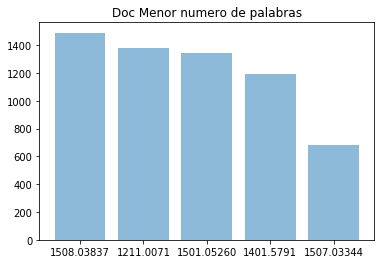

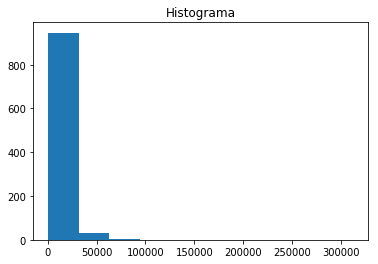

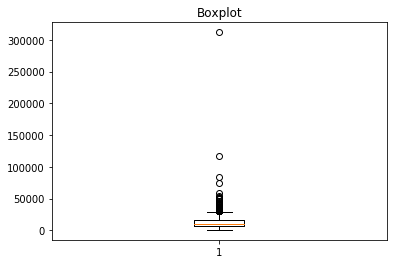

In [6]:
files_txt = glob.glob("/opt/datasets/mcda-pi1-20191/papers-txt/*.txt")
# instanciar la clase para lematizar
wordnet_lemmatizer = WordNetLemmatizer()
# llamamos al diccionario de stop words en ingles
sw = stopwords.words("english")

bag_of_words_descriptivo = {}
estadisticas_tamano = {}
for file in files_txt:
    #Leer Informacion
    input_file = open(file,"r",encoding='utf-8')
    texto = input_file.read()
    file = file.split("/")[5].replace(".txt","")
    bag_of_words_descriptivo[file] = texto
    estadisticas_tamano[file]=len(texto.split())
print("El tamaño total de documentos es de {}".format(len(bag_of_words_descriptivo)))
mostrar_info(estadisticas_tamano, "sin ningun proceso de limpieza")

Info despues de dejar solo elementos alfanumericos:
    - minimo:   636
    - maximo:   307608
    - promedio: 12372.666326530612
    - mediana:  10039.5
    - total:    12125213
    


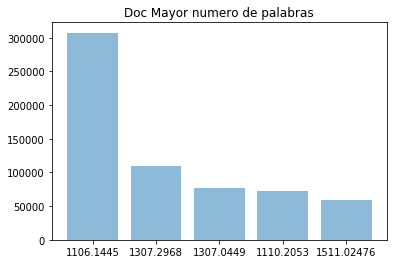

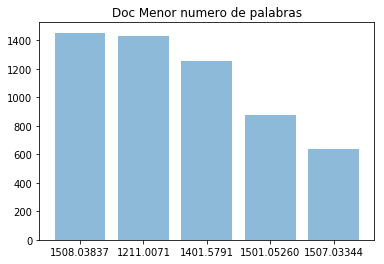

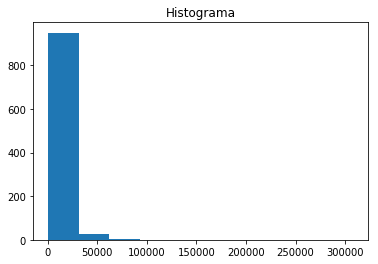

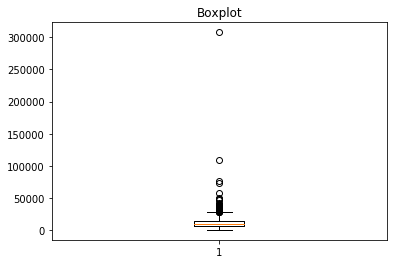

In [7]:
estadisticas_tamano = {}
for documento in bag_of_words_descriptivo.keys():
    texto = re.sub('[^A-Za-z0-9]+',' ', bag_of_words_descriptivo[documento])
    bag_of_words_descriptivo[documento] = texto.split()
    estadisticas_tamano[documento] = len(bag_of_words_descriptivo[documento])
    #despues de quitar solo elementos alfanumericos
mostrar_info(estadisticas_tamano,"despues de dejar solo elementos alfanumericos")

Info despues de eliminar palabras de 1 caracter:
    - minimo:   465
    - maximo:   246446
    - promedio: 9786.543877551021
    - mediana:  8120.0
    - total:    9590813
    


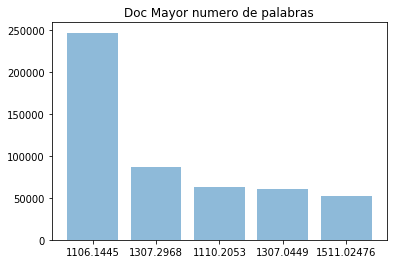

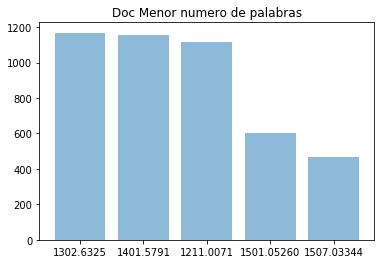

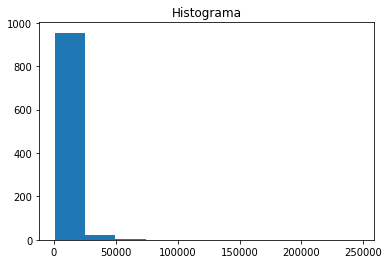

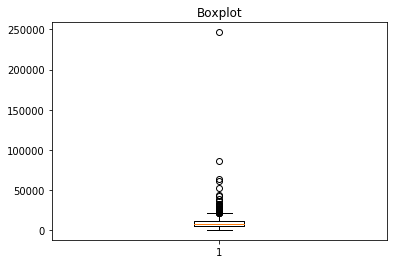

In [8]:
estadisticas_tamano = {}
for documento in bag_of_words_descriptivo.keys():
    bag_of_words_descriptivo[documento] = [w for w in bag_of_words_descriptivo[documento] if (len(w)>1)]
    estadisticas_tamano[documento] = len(bag_of_words_descriptivo[documento])
mostrar_info(estadisticas_tamano,"despues de eliminar palabras de 1 caracter")

Info despues de eliminar stopwords:
    - minimo:   317
    - maximo:   164822
    - promedio: 6427.4
    - mediana:  5383.0
    - total:    6298852
    


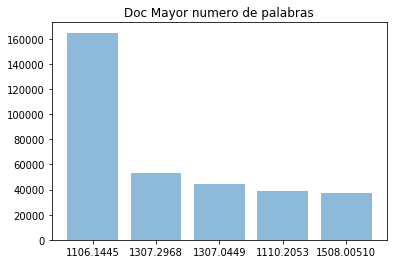

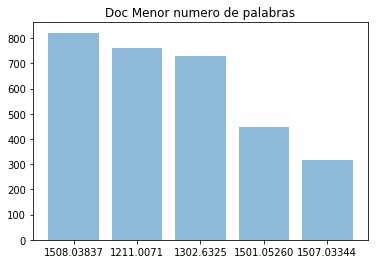

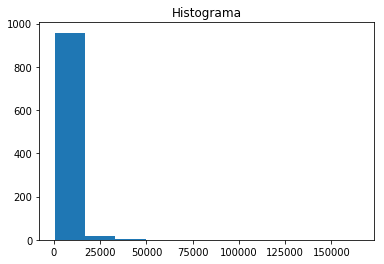

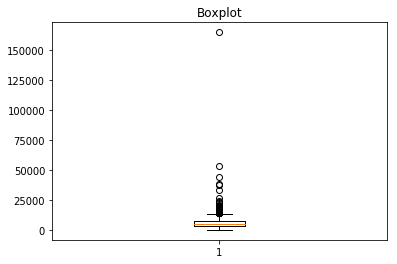

In [9]:
estadisticas_tamano = {}
for documento in bag_of_words_descriptivo.keys():
    bag_of_words_descriptivo[documento] = [w for w in bag_of_words_descriptivo[documento] if (w not in sw)]
    estadisticas_tamano[documento] = len(bag_of_words_descriptivo[documento])
mostrar_info(estadisticas_tamano,"despues de eliminar stopwords")

Info despues de eliminar palabras que no son del ingles:
    - minimo:   239
    - maximo:   130360
    - promedio: 5018.370408163265
    - mediana:  4123.0
    - total:    4918003
    


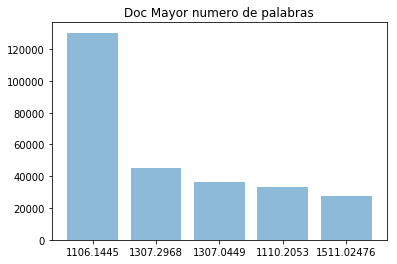

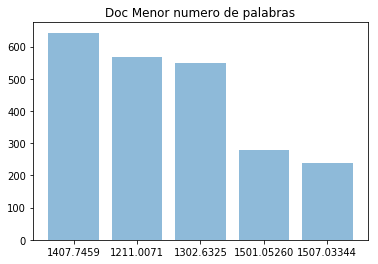

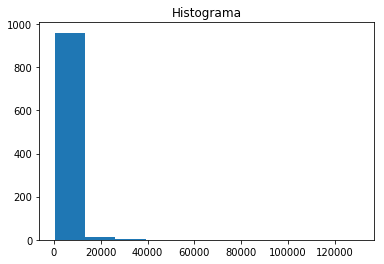

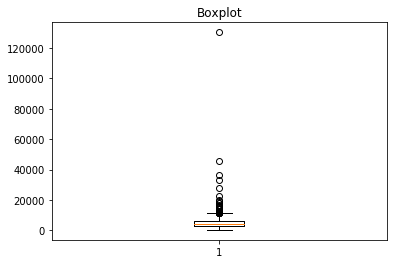

In [11]:
estadisticas_tamano = {}
for documento in bag_of_words_descriptivo.keys():
    bag_of_words_descriptivo[documento] = [w for w in bag_of_words_descriptivo[documento] if wordnet.synsets(w)]
    estadisticas_tamano[documento] = len(bag_of_words_descriptivo[documento])
mostrar_info(estadisticas_tamano,"despues de eliminar palabras que no son del ingles")

Info despues de eliminar palabras:
    - minimo:   237
    - maximo:   121228
    - promedio: 4754.417346938775
    - mediana:  3884.0
    - total:    4659329
    


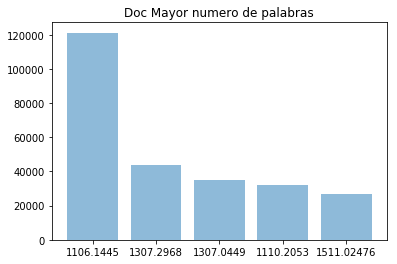

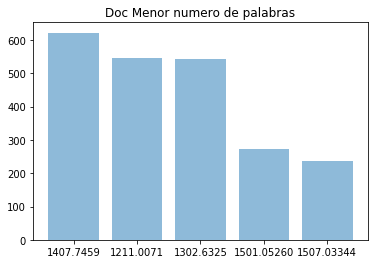

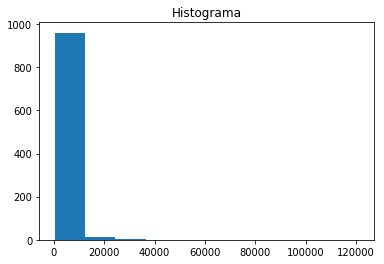

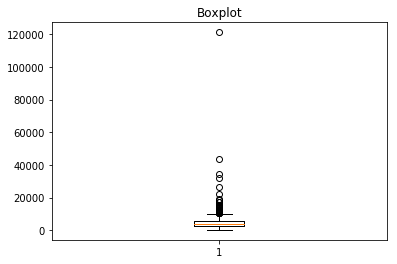

In [13]:
estadisticas_tamano = {}
for documento in bag_of_words_descriptivo.keys():
    bag_of_words_descriptivo[documento] = [w for w in bag_of_words_descriptivo[documento] if w.isalpha()]
    estadisticas_tamano[documento] = len(bag_of_words_descriptivo[documento])
mostrar_info(estadisticas_tamano,"despues de eliminar palabras")